In [1]:
#coding=utf-8

import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import math
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import joblib
import scorecard as sc

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
sns.set(context='notebook',font='simhei',style='whitegrid')
# 设置风格尺度和显示中文
import warnings
warnings.filterwarnings('ignore')



'''单变量特征选取'''
from sklearn.feature_selection import SelectKBest, chi2
'''去除方差小的特征'''
from sklearn.feature_selection import VarianceThreshold
'''循环特征选取'''
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
'''RFE_CV'''
from sklearn.ensemble import ExtraTreesClassifier


UsageError: Line magic function `%` not found.


In [2]:
path = 'C:/Users/home/myself/A1/'
train_application = pd.read_csv('train/train_Application.csv')
train_history_application = pd.read_csv('train/train_History_Application.csv')    # (647963, 32)
train_history_payment = pd.read_csv('train/train_History_Payment.csv')
train_personas = pd.read_csv('train/train_Personas.csv')
train_label = pd.read_csv('train/train_label.csv')

A_application = pd.read_csv('A/A_Application.csv')
A_history_application = pd.read_csv('A/A_History_Application.csv')    # (97021, 32)
A_history_payment = pd.read_csv('A/A_History_Payment.csv')
A_personas = pd.read_csv('A/A_Personas.csv')


train_application_label = pd.merge(train_application,train_label)    # (140000, 31)
# print('贷款申请信息：',train_Application_label.shape)
train_base = pd.merge(train_application_label,train_personas)
# print('客户贷款基础信息：',train_base.shape)   # (140000, 63)
train_base.head()

A_application['标签'] = -1
A_base = pd.merge(A_application,A_personas)
# print(A_base.shape)   # (21511, 63)

all_train_base = pd.concat([train_base,A_base],axis=0)
all_train_base = all_train_base.reset_index(drop = True)
print('all_train_base:',all_train_base.shape)

all_history_application = pd.concat([train_history_application,A_history_application],axis=0)
all_history_application = all_history_application.reset_index(drop = True)
print('all_history_application',all_history_application.shape)

all_history_payment = pd.concat([train_history_payment,A_history_payment],axis=0)
all_history_payment = all_history_payment.reset_index(drop = True)
print('all_history_payment',all_history_payment.shape)

all_train_base: (161511, 63)
all_history_application (744984, 32)
all_history_payment (6058093, 8)


In [3]:
data = all_train_base.fillna(0)
train_data = data[data['标签']!=-1].drop(columns='申请编号',axis=1)
test_data = data[data['标签']==-1].drop(columns = ['申请编号','标签'])
print('train_data：',train_data.shape,'\ntest_data：',test_data.shape)

x = train_data.drop(columns = '标签')
y = train_data['标签']
print('train_x：',x.shape,'\ntrain_label：',y.shape)

train_data： (140000, 62) 
test_data： (21511, 61)
train_x： (140000, 61) 
train_label： (140000,)


## 回归

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=1024)

#对数据的训练集进行标准化
ss = StandardScaler()
x_train = ss.fit_transform(x_train)     #先拟合数据在进行标准化

In [7]:
x_train.shape

(105000, 61)

In [16]:
x.标签

AttributeError: 'DataFrame' object has no attribute '标签'

In [17]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
lr.predict_proba(x_test)

C:\Users\home\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

C:\Users\home\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


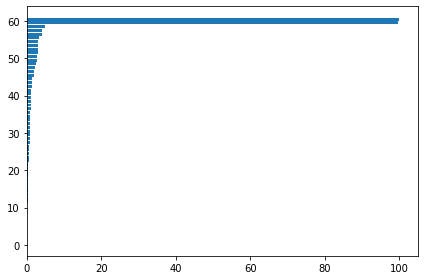

In [119]:

clf = LogisticRegression(random_state = 0)
clf.fit(x_train, y_train)

feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
# featax.set_yticks(pos)
# featax.set_yticklabels(np.array(x_train.columns)[sorted_idx], fontsize=20)
# featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [110]:
y_pred = model_lr.predict(x_test)

In [111]:
y_pred

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [108]:
model_lr.predict_proba(x_test)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [ ]:
confusion_matrix=confusion_matrix(y_test,y_pred)

In [102]:
res = model_lr.score(x_train,y_train)
print("R值(准确率):",res)
print("参数:",model_lr.coef_)
print("截距:",model_lr.intercept_)
print("稀疏化特征比率:%.2f%%" %(np.mean(model_lr.coef_.ravel()==0)*100))
print("=========sigmoid函数转化的值，即：概率p=========")
print(model_lr.predict_proba(x_test))     #sigmoid函数转化的值，即：概率p


R值(准确率): 0.851152380952381
参数: [[-1.65935351e-01  1.46543753e-01  8.51992427e-02 -2.38587077e-01
   4.31073591e-02  1.95727173e-01  5.89640205e+00  6.43376189e-02
   1.13843753e-01  5.88462086e+00  4.94235895e-02 -2.27879594e-02
   8.75212252e-03  8.48949037e-03 -2.68897813e-02 -1.75655351e-01
  -1.96688765e-02 -1.68358702e-02 -1.15482471e-02  1.82705783e-03
   1.31686043e-02 -5.08980426e-02 -5.41342385e-02 -8.32778078e-03
  -1.53352728e-03  9.40210777e-03  1.37764184e-03 -1.50520471e-02
  -2.81032564e-02  6.48763200e-02  1.69370985e-01 -1.80941470e-01
   1.88566603e-02  2.33095434e-01  2.69279366e-03  6.16759387e-02
   1.77762992e-01 -1.11400361e-01  1.04519296e-02  3.49616400e-03
   7.86409038e-02  4.83514109e-02 -2.89006958e-01 -4.90096699e-02
   4.23588018e-02  2.49330009e-02 -8.35766440e-02  4.95693297e-02
   1.25162996e-01  1.45652426e-02  7.37579288e-02 -3.14981346e-02
   5.66393357e-02 -2.62441579e-02 -3.89951901e-02 -1.52971006e-02
  -4.94445228e-02  5.91036315e-02  6.28311109

In [103]:
predict_proba = model_lr.predict_proba(x_test)

In [106]:
feature_impotance = pd.DataFrame({'fea':list(x.columns),
             'impotance':model_lr.coef_[0].tolist()})
pd.set_option('display.max_row',None)
feature_impotance.sort_values(by = ['impotance'],ascending=False)

,fea,impotance
6,工作日期距申请日期天数,5.896402
9,是否提供手机号,5.884621
33,孩子个数,0.233095
5,出生日期距申请日期天数,0.195727
36,教育程度,0.177763
30,性别,0.169371
60,最近一次换手机号码距申请日天数,0.161070
1,信用额度,0.146544
48,客户居住地评分2,0.125163
8,身份认证日期距申请日期天数,0.113844


## 贝叶斯


In [12]:
clf=GaussianNB()
y_pred = clf.fit(x, y).predict(test_data)
y_proba = clf.predict_proba(test_data)[:,1].tolist()

In [13]:
y_proba

[0.029103079401808056,
 0.056747094622689224,
 0.011016902876845725,
 0.13218468468151287,
 0.012949646134101532,
 0.13527502333226676,
 0.12007258439009305,
 0.015233591679588833,
 0.0019973589750628628,
 0.02710737926362102,
 0.08252528071449636,
 0.09147543553627598,
 0.010816095408896208,
 0.06695519082393704,
 0.033353287630901646,
 0.059868096582114866,
 0.030141881038912438,
 0.03680057071854473,
 0.08623340535728992,
 0.036115785073327404,
 0.004364415915117383,
 0.03890626395603583,
 0.059311982757955,
 0.004995901200484418,
 0.005698283889013964,
 0.06885116224684251,
 0.0805092048276102,
 0.04237428924456246,
 0.061189313419828015,
 0.03550090549396375,
 0.08480459023550195,
 0.8123446444570054,
 0.02761973507133183,
 0.1113313583467162,
 0.045140229799603505,
 0.06551530674147868,
 0.12363583786483703,
 0.02144527840081192,
 0.10390648893162423,
 0.06843281523381474,
 0.09196718328982773,
 0.00953853537478353,
 0.13316426624329725,
 0.1458058068210596,
 0.0634344387001719,


In [25]:
clf=GaussianNB()
clf.fit(x,y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:

clf.set_params(priors=[0.333, 0.333, 0.333])#这里要设一下各个类标记对应的先验概率，如果不设置直接clf.priors返回的是None(不知道为什么？)
print(clf.priors)                           #获取各个类标记对应的先验概率
print(clf.class_prior_ )                    #同priors一样，都是获取各个类标记对应的先验概率，区别在于priors属性返回列表，class_prior_返回的是数组
print(clf.get_params(deep=True))            #返回priors与其参数值组成字典
 
print(clf.class_count_)                     #获取各类标记对应的训练样本数
print(clf.theta_)                           #获取各个类标记在各个特征上的均值
print(clf.sigma_)                           #获取各个类标记在各个特征上的方差


[0.333, 0.333, 0.333]
[0.85 0.15]
{'priors': [0.333, 0.333, 0.333], 'var_smoothing': 1e-09}
[119000.  21000.]
[[ 9.77731092e-02  4.79752633e+05  1.71319394e+04  4.29996858e+05
   6.04486555e+00 -1.28901431e+04  5.23876469e+04 -4.00547520e+03
  -2.40543271e+03  8.15252101e-01  1.96436975e-01  9.98126050e-01
   5.83277311e-02  3.08643697e+00  5.79610084e+00  2.12660667e-01
   1.50420168e-02  4.22689076e-03  2.01680672e-04  6.47058824e-04
   3.36134454e-05  8.14789916e-02  1.01596639e-02  8.98319328e-02
   5.52941176e-03  6.14285714e-03  2.94285714e-02  2.58025210e-01
   2.38915966e-01  1.95057143e+00  3.34117647e-01  3.44235294e-01
   6.94831933e-01 -5.87873950e-01  2.37335708e+05  4.63378992e+00
   3.16579832e+00  1.47809244e+00  1.28193277e+00  1.93108580e-02
   1.96989916e+00  5.46723529e+00  1.14825210e+00  2.32288318e-01
   2.35938207e-02  6.04936110e-02  6.01506022e-02  1.04409244e+00
   1.02364706e+00  5.06722689e-02  7.51344538e-02  4.09411765e-02
   1.75932773e-01  1.48487395e-0

In [ ]:
from sklearn.naive_bayes import MultinomialNB   # 输入不能是负数
clf = MultinomialNB()
y_pred = clf.fit(x, y).predict(test_data)
y_proba = clf.predict_proba(test_data)[:,1].tolist()

In [37]:
#测试数据
# data_test=np.array([6,4,6,2])
# data=data_test.reshape(1,-1)
Result_predict=clf.predict(test_data)   #预测所属类别
# Score=clf.score(test_data,[0,1])
 
Result_predict_proba=clf.predict_proba(test_data)   #输出测试样本在各个类标记上预测概率值
Result_predict_log_proba=clf.predict_log_proba(test_data)   #输出测试样本在各个类标记上预测概率值对应对数值


In [34]:
Result_predict.tolist()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [32]:
Result_predict_proba.tolist()

[[0.9708969205982002, 0.029103079401808056],
 [0.9432529053773007, 0.056747094622689224],
 [0.9889830971231638, 0.011016902876845725],
 [0.8678153153184824, 0.13218468468151287],
 [0.9870503538659037, 0.012949646134101532],
 [0.86472497666772, 0.13527502333226676],
 [0.8799274156099036, 0.12007258439009305],
 [0.9847664083204181, 0.015233591679588833],
 [0.9980026410249333, 0.0019973589750628628],
 [0.9728926207363854, 0.02710737926362102],
 [0.9174747192855007, 0.08252528071449636],
 [0.908524564463718, 0.09147543553627598],
 [0.9891839045910967, 0.010816095408896208],
 [0.9330448091760577, 0.06695519082393704],
 [0.9666467123691026, 0.033353287630901646],
 [0.9401319034178777, 0.059868096582114866],
 [0.9698581189610859, 0.030141881038912438],
 [0.9631994292814523, 0.03680057071854473],
 [0.9137665946427079, 0.08623340535728992],
 [0.9638842149266748, 0.036115785073327404],
 [0.9956355840848864, 0.004364415915117383],
 [0.9610937360439572, 0.03890626395603583],
 [0.9406880172420563, 

In [35]:
Result_predict_log_proba

array([[-0.02953497, -3.53691129],
       [-0.05842084, -2.86915082],
       [-0.01107804, -4.50832456],
       ...,
       [-0.07875083, -2.58058351],
       [-0.10157466, -2.33731864],
       [-0.07037504, -2.68889776]])

In [17]:
from sklearn import datasets
iris=datasets.load_iris()
iris.data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [5]:
import math

Iris_setosa_data=[]
Iris_versicolor_data=[]
Iris_virginica_data=[]

#读取训练数据集，这里我将每种花取前45条数据，剩下的5条数据另外存入测试数据集

def read_train_data(filename):
    f=open(filename,'r')
    all_lines=f.readlines()
    for line in all_lines[0:45]:
        line=line.strip().split(',')
        Iris_setosa_data.append(line[0:4])
        #Iris_setosa_label+=1
    for line in all_lines[51:95]:
        line=line.strip().split(',')
        Iris_versicolor_data.append(line[0:4])
        #Iris_versicolor_label+=1
    for line in all_lines[101:145]:
        line=line.strip().split(',')
        Iris_virginica_data.append(line[0:4])
        #Iris_virginica_label+=1
    return Iris_setosa_data,Iris_versicolor_data,Iris_virginica_data

test_data=[]
#读取测试数据集
def read_test_data(testname):
    f=open(testname,'r')
    all_lines=f.readlines()
    for line in all_lines[0:]:
        line=line.strip().split(',')   #以逗号为分割符拆分列表
        test_data.append(line)
    return test_data

In [8]:
Iris_setosa_data,Iris_versicolor_data,Iris_virginica_data=read_train_data('iris_data.txt')

In [13]:
Iris_setosa_data

[['5.1', '3.5', '1.4', '0.2'],
 ['4.9', '3.0', '1.4', '0.2'],
 ['4.7', '3.2', '1.3', '0.2'],
 ['4.6', '3.1', '1.5', '0.2'],
 ['5.0', '3.6', '1.4', '0.2'],
 ['5.4', '3.9', '1.7', '0.4'],
 ['4.6', '3.4', '1.4', '0.3'],
 ['5.0', '3.4', '1.5', '0.2'],
 ['4.4', '2.9', '1.4', '0.2'],
 ['4.9', '3.1', '1.5', '0.1'],
 ['5.4', '3.7', '1.5', '0.2'],
 ['4.8', '3.4', '1.6', '0.2'],
 ['4.8', '3.0', '1.4', '0.1'],
 ['4.3', '3.0', '1.1', '0.1'],
 ['5.8', '4.0', '1.2', '0.2'],
 ['5.7', '4.4', '1.5', '0.4'],
 ['5.4', '3.9', '1.3', '0.4'],
 ['5.1', '3.5', '1.4', '0.3'],
 ['5.7', '3.8', '1.7', '0.3'],
 ['5.1', '3.8', '1.5', '0.3'],
 ['5.4', '3.4', '1.7', '0.2'],
 ['5.1', '3.7', '1.5', '0.4'],
 ['4.6', '3.6', '1.0', '0.2'],
 ['5.1', '3.3', '1.7', '0.5'],
 ['4.8', '3.4', '1.9', '0.2'],
 ['5.0', '3.0', '1.6', '0.2'],
 ['5.0', '3.4', '1.6', '0.4'],
 ['5.2', '3.5', '1.5', '0.2'],
 ['5.2', '3.4', '1.4', '0.2'],
 ['4.7', '3.2', '1.6', '0.2'],
 ['4.8', '3.1', '1.6', '0.2'],
 ['5.4', '3.4', '1.5', '0.4'],
 ['5.2',

In [10]:
calculate_mean_std(Iris_setosa_data)

(10.02222222222222,
 6.8400000000000025,
 2.9288888888888893,
 0.493333333333333,
 50.47955555555549,
 23.68844444444449,
 4.353333333333334,
 0.14622222222222186)

In [9]:


#计算均值和方差
def calculate_mean_std(train_data):
    x1_sum=0.0
    x2_sum=0.0
    x3_sum=0.0
    x4_sum=0.0

    for x in train_data: #计算各个特征的和
        x1_sum+=float(x[0])
        x2_sum+=float(x[1])
        x3_sum+=float(x[2])
        x4_sum+=float(x[3])
        #print(x[0],x[1],x[2],x[3])
    #计算样本在各个属性上取值的均值
    u_x1=x1_sum/45
    u_x2=x2_sum/45
    u_x3=x3_sum/45
    u_x4=x4_sum/45
   
    k1=0.0
    k2=0.0
    k3=0.0
    k4=0.0
    #计算各类样本在第i个属性上的方差
    for x in train_data:
        k1+=(float(x[0])-u_x1)**2
        k2+=(float(x[1])-u_x2)**2
        k3+=(float(x[2])-u_x3)**2
        k4+=(float(x[3])-u_x4)**2
    variance_x1=k1/45
    variance_x2=k2/45
    variance_x3=k3/45
    variance_x4=k4/45

    return u_x1,u_x2,u_x3,u_x4,variance_x1,variance_x2,variance_x3,variance_x4

#计算每个属性估计条件概率    
def calculate_P_xi_c(u_x1,u_x2,u_x3,u_x4,variance_x1,variance_x2,variance_x3,variance_x4,line_data):
    p_x1_c=(1/math.sqrt(2*math.pi))*math.exp(-(float(line_data[0])-u_x1)**2/(2*variance_x1))
    p_x2_c=(1/math.sqrt(2*math.pi))*math.exp(-(float(line_data[1])-u_x2)**2/(2*variance_x2))
    p_x3_c=(1/math.sqrt(2*math.pi))*math.exp(-(float(line_data[2])-u_x3)**2/(2*variance_x3))
    p_x4_c=(1/math.sqrt(2*math.pi))*math.exp(-(float(line_data[3])-u_x4)**2/(2*variance_x4))

    return p_x1_c,p_x2_c,p_x3_c,p_x4_c


    
if __name__ == '__main__':
    filename='iris_data.txt'
    testname='iris_test_data.txt'
    Iris_setosa_data,Iris_versicolor_data,Iris_virginica_data=read_train_data(filename)
    
    #Iris_setosa种类的各个特征属性上的均值和方差
    Iris_setosa_u_x1,Iris_setosa_u_x2,Iris_setosa_u_x3,Iris_setosa_u_x4,\
    Iris_setosa_variance_x1,Iris_setosa_variance_x2,Iris_setosa_variance_x3,\
    Iris_setosa_variance_x4=calculate_junzhi_and_fangcha(Iris_setosa_data)
    #Iris_versicolor种类的各个特征属性上的均值和方差
    Iris_versicolor_u_x1,Iris_versicolor_u_x2,Iris_versicolor_u_x3,Iris_versicolor_u_x4,\
    Iris_versicolor_variance_x1,Iris_versicolor_variance_x2,Iris_versicolor_variance_x3,\
    Iris_versicolor_variance_x4=calculate_junzhi_and_fangcha(Iris_versicolor_data)
    #Iris_virginica种类的各个特征属性上的均值和方差
    Iris_virginica_u_x1,Iris_virginica_u_x2,Iris_virginica_u_x3,Iris_virginica_u_x4,\
    Iris_virginica_variance_x1,Iris_virginica_variance_x2,Iris_virginica_variance_x3,\
    Iris_virginica_variance_x4=calculate_junzhi_and_fangcha(Iris_virginica_data)
    
    '''开始测试'''
    test_data=read_test_data(testname)
    #print ('test_data',test_data)
    #估计类先验概率
    p1=len(Iris_setosa_data)/(len(Iris_versicolor_data)+len(Iris_virginica_data)+len(Iris_setosa_data))
    p2=len(Iris_versicolor_data)/(len(Iris_versicolor_data)+len(Iris_virginica_data)+len(Iris_setosa_data))
    p3=len(Iris_virginica_data)/(len(Iris_versicolor_data)+len(Iris_virginica_data)+len(Iris_setosa_data))
    for x in test_data:
        #在Iris_setosa种类上的各个特征属性的条件概率
        P_x1_Iris_setosa,P_x2_Iris_setosa,P_x3_Iris_setosa,P_x4_Iris_setosa=calculate_P_xi_c(Iris_setosa_u_x1,Iris_setosa_u_x2,Iris_setosa_u_x3,Iris_setosa_u_x4,\
        Iris_setosa_variance_x1,Iris_setosa_variance_x2,Iris_setosa_variance_x3,Iris_setosa_variance_x4,x)
        #print(P_x1_Iris_setosa,P_x2_Iris_setosa,P_x3_Iris_setosa,P_x4_Iris_setosa)
        
        #在Iris_versicolor种类上的各个特征属性的条件概率
        P_x1_Iris_versicolor,P_x2_Iris_versicolor,P_x3_Iris_versicolor,P_x4_Iris_versicolor=calculate_P_xi_c(Iris_versicolor_u_x1,Iris_versicolor_u_x2,Iris_versicolor_u_x3,Iris_versicolor_u_x4,\
        Iris_versicolor_variance_x1,Iris_versicolor_variance_x2,Iris_versicolor_variance_x3,Iris_versicolor_variance_x4,x)
        #print(P_x1_Iris_versicolor,P_x2_Iris_versicolor,P_x3_Iris_versicolor)

        #在Iris_virginica种类上的各个特征属性的条件概率
        P_x1_Iris_virginica,P_x2_Iris_virginica,P_x3_Iris_virginica,P_x4_Iris_virginica=calculate_P_xi_c(Iris_virginica_u_x1,Iris_virginica_u_x2,Iris_virginica_u_x3,Iris_virginica_u_x4,\
        Iris_virginica_variance_x1,Iris_virginica_variance_x2,Iris_virginica_variance_x3,Iris_virginica_variance_x4,x)
        #print(P_x1_Iris_virginica,P_x2_Iris_virginica,P_x3_Iris_virginica,P_x4_Iris_virginica)

        #计算各个种类上的后验概率
        P_Iris_setosa=p1*P_x1_Iris_setosa*P_x2_Iris_setosa*P_x3_Iris_setosa*P_x4_Iris_setosa
        #print( P_Iris_setosa)
        P_Iris_versicolor=p2*P_x1_Iris_versicolor*P_x2_Iris_versicolor*P_x3_Iris_versicolor*P_x4_Iris_versicolor
        #print( P_Iris_versicolor)
        P_Iris_virginica=p3*P_x1_Iris_virginica*P_x2_Iris_virginica*P_x3_Iris_virginica*P_x4_Iris_virginica
        #print( P_Iris_virginica)

        if P_Iris_setosa>P_Iris_versicolor and P_Iris_setosa>P_Iris_virginica:
            print(x[0],x[1],x[2],x[3],":这行数据属于Iris_setosa类")
        if P_Iris_versicolor>P_Iris_setosa and P_Iris_versicolor>P_Iris_virginica:
            print(x[0],x[1],x[2],x[3],":这行数据属于Iris_versicolor类")      
        if P_Iris_virginica>P_Iris_setosa and P_Iris_virginica>P_Iris_versicolor:
            print(x[0],x[1],x[2],x[3],":这行数据属于Iris_virginica类")

NameError: name 'calculate_junzhi_and_fangcha' is not defined